In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

file = 'save'
train_size = 81*10**6
d = 5

#### Trend of loss

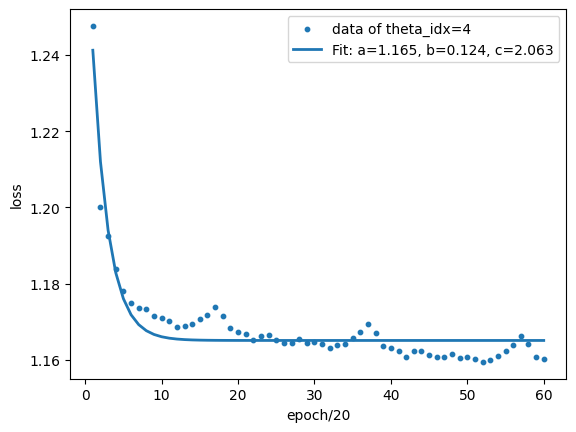

In [9]:
theta_idx = 4 # now we have theta_idx = 2, 4, 8, corresponding to theta=0.31(area), 0.62(critical), 1.26(volume)
epoch_max = 2 # trained for 3 epochs


l_train = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_train.pt')
l_test = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_test.pt')
all_Sqc_test = l_test['msk off Sqc']
all_loss = l_train['loss']

# Prepare data
x_data = np.arange(len(all_loss))[1:]
y_data = np.array(all_loss)[1:] # remove the first loss value, which is the initial loss before training

# Define fitting function
def exp_decay(x, a, b, c):
    return a + b * np.exp(-x / c)


# Fit the curve
popt, pcov = curve_fit(exp_decay, x_data, y_data, p0=[1,1,5])

# Plot original data and fitted curve
plt.scatter(x_data, y_data, s=10, label=f'data of theta_idx={theta_idx}')
plt.plot(x_data, exp_decay(x_data, *popt), linewidth=2, label=f'Fit: a={popt[0]:.3f}, b={popt[1]:.3f}, c={popt[2]:.3f}')
#plt.ylim(0.2, 1.4)
plt.xlabel('epoch/20')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Trend of Sqc

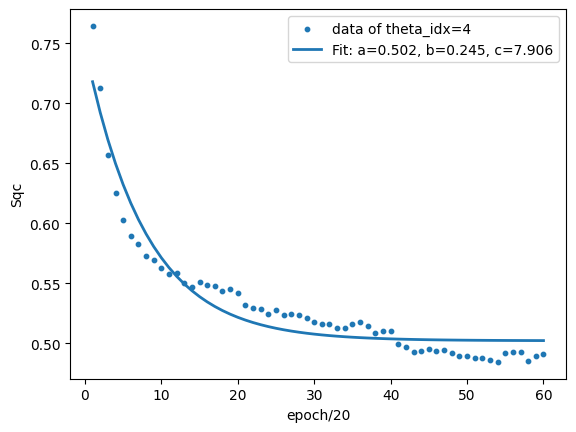

In [10]:
theta_idx = 4 # now we have theta_idx = 2, 4, 8, corresponding to theta=0.31(area), 0.62(critical), 1.26(volume)
epoch_max = 2 # trained for 3 epochs

l_train = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_train.pt')
l_test = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_test.pt')
all_Sqc_test = l_test['msk off Sqc']
all_loss = l_train['loss']

# Prepare data
x_data = np.arange(len(all_Sqc_test))[1:]
y_data = np.array(all_Sqc_test)[1:] # remove the first Sqc value, which is the initial Sqc before training

# Define fitting function
def exp_decay(x, a, b, c):
    return a + b * np.exp(-x / c)


# Fit the curve
popt, pcov = curve_fit(exp_decay, x_data, y_data, p0=[1,2,1])

# Plot original data and fitted curve
plt.scatter(x_data, y_data, s=10, label=f'data of theta_idx={theta_idx}')
plt.plot(x_data, exp_decay(x_data, *popt), linewidth=2, label=f'Fit: a={popt[0]:.3f}, b={popt[1]:.3f}, c={popt[2]:.3f}')
#plt.ylim(0.2, 1.4)
plt.xlabel('epoch/20')
plt.ylabel('Sqc')
plt.legend()
plt.show()